This program takes hours to run mainly due to the hyperparameter optimization section. Up untill there it can be run within 10 min or so.

**Install modules**

In [ ]:
#install/update required modules
#need to restart runtime after installing to update the installed modules

!pip install --upgrade matplotlib

!pip install --upgrade gensim

!pip install --user -U nltk

!pip install contractions

**Import modules**



In [2]:
#data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#data cleaning
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
import string
import re
import html

#visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#word embeddings
import gensim
from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#classifiers
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

#evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

**Import dataset and store  in a pandas dataframe**

In [3]:
#read dataset file - put dataset file in google colab default directory or change path to wherever it is
datasetDF = pd.read_csv('disasterTweetDataset.csv', encoding ='ISO-8859-1')
datasetDF.head() 

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


Remove unnecessary data, clarify column names, map class label text to 0s and 1s

In [4]:
datasetDF = datasetDF.drop(columns=['_unit_id','_golden', '_unit_state','_trusted_judgments', '_last_judgment_at', 'choose_one:confidence', 'choose_one_gold', 'userid','tweetid'])
datasetDF = datasetDF.rename(columns={'choose_one':'target'}) 
datasetDF.target = datasetDF.target.map({'Relevant': 1, 'Not Relevant': 0})
datasetDF.head()

,target,keyword,location,text
0,1.0,NaN,NaN,Just happened a terrible car crash
1,1.0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
2,1.0,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,1.0,NaN,NaN,"there is a forest fire at spot pond, geese are..."
4,1.0,NaN,NaN,Forest fire near La Ronge Sask. Canada


Find missing data counts

In [5]:
datasetDF.isnull().sum()

target        16
keyword       87
location    3638
text           0
dtype: int64

Fill in missing data

In [6]:
datasetDF["target"] = datasetDF["target"].fillna(0)
tweetData = datasetDF

In [7]:
datasetDF

,target,keyword,location,text
0,1.0,NaN,NaN,Just happened a terrible car crash
1,1.0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
2,1.0,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,1.0,NaN,NaN,"there is a forest fire at spot pond, geese are..."
4,1.0,NaN,NaN,Forest fire near La Ronge Sask. Canada
...,...,...,...,...
10871,1.0,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
10872,1.0,NaN,NaN,Police investigating after an e-bike collided ...
10873,1.0,NaN,NaN,The Latest: More Homes Razed by Northern Calif...
10874,1.0,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


**Data cleaning**

Get required NLP word packages

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

Remove stopwords function

In [9]:
def remove_stopwords(text):

  stop_words = stopwords.words('english') #NTLK english stopword list
  new_text = []
  for word in text.split(): #split text into words
    if word not in stop_words: #remove stopwords
      new_text.append(word) 

  return ' '.join(new_text) #return string with no stopwords

Lemmatize function

In [10]:
def lemmatize(text):

  lemmatizer = WordNetLemmatizer() #NTLK lemmatizer

  lemmatized_text = []

  for word in text.split(): #Lemmatize each word
    if word != 'us':
      lemmatized_text.append(lemmatizer.lemmatize(word))

  return ' '.join(lemmatized_text)


Apply data cleaning steps

In [11]:
#Clean tweet text, store cleaned text in new data frame column 'clean_text'

tweetData['clean_text'] = tweetData.text.apply(lambda tweet : contractions.fix(tweet)) #Expand contractions

tweetData['clean_text'] = tweetData['clean_text'].str.lower() #Make all tweets lower-case

tweetData['clean_text'] = tweetData.clean_text.apply(lambda tweet : re.sub('https?:\/\/[^\s]*', '', tweet)) #Remove URLs

tweetData['clean_text'] = tweetData.clean_text.apply(lambda tweet : html.unescape(tweet)) #Remove HTML entities

tweetData['clean_text'] = tweetData.clean_text.apply(lambda tweet : remove_stopwords(tweet)) #Remove stopwords

tweetData['clean_text'] = tweetData.clean_text.apply(lambda tweet : tweet.translate(str.maketrans('', '', string.punctuation))) #Remove punctuation

tweetData['clean_text'] = tweetData.clean_text.apply(lambda tweet : lemmatize(tweet)) #Lemmatize

tweetData['clean_text'] = tweetData.clean_text.apply(lambda tweet : re.sub('\x89û', '', tweet)) #Remove 

In [12]:
tweetData[['text', 'clean_text']].head()

,text,clean_text
0,Just happened a terrible car crash,happened terrible car crash
1,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive
2,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
3,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
4,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada


**Processes data**

Seperate disaster tweets from non-disaster tweets

In [13]:
disasterTweets = tweetData.loc[tweetData['target'] == 1] 
nonDisasterTweets = tweetData.loc[tweetData['target'] == 0]

Pie-chart showing dataset class balance

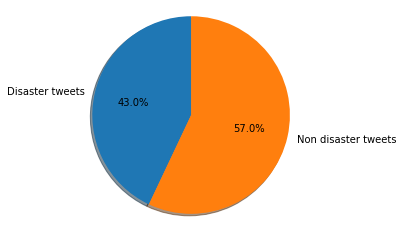

In [14]:
disasterCount = disasterTweets.target.count()
nonDisasterCount = nonDisasterTweets.target.count()

labels = ["Disaster tweets", "Non disaster tweets"]
sizes = [disasterCount, nonDisasterCount]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


Count how many times specific words appear in disaster / non disaster tweets

In [15]:
wordCount_disaster = {} #dictionaries for word count <word>:<number of times word appears>
wordCount_nonDisaster = {}

for tweet in disasterTweets.clean_text:
  for word in tweet.split():
    if word not in wordCount_disaster:
      wordCount_disaster[word] = 1
    else:
      wordCount_disaster[word] = wordCount_disaster[word] + 1

for tweet in nonDisasterTweets.clean_text:
  for word in tweet.split():
    if word not in wordCount_nonDisaster:
      wordCount_nonDisaster[word] = 1
    else:
      wordCount_nonDisaster[word] = wordCount_nonDisaster[word] + 1

Find the most common words in both tweet classes

In [16]:
topWords_disaster = sorted(wordCount_disaster, key=wordCount_disaster.get,reverse=True)[:10] #get names of top 10 words
topWordCounts_disaster = []
for word in topWords_disaster: #get word counts for top 10 words
  topWordCounts_disaster.append(wordCount_disaster[word])

#top 10 non-disaster words
topWords_nonDisaster = sorted(wordCount_nonDisaster, key=wordCount_nonDisaster.get,reverse=True)[:10] 
topWordCounts_nonDisaster = []
for word in topWords_nonDisaster:
  topWordCounts_nonDisaster.append(wordCount_nonDisaster[word])

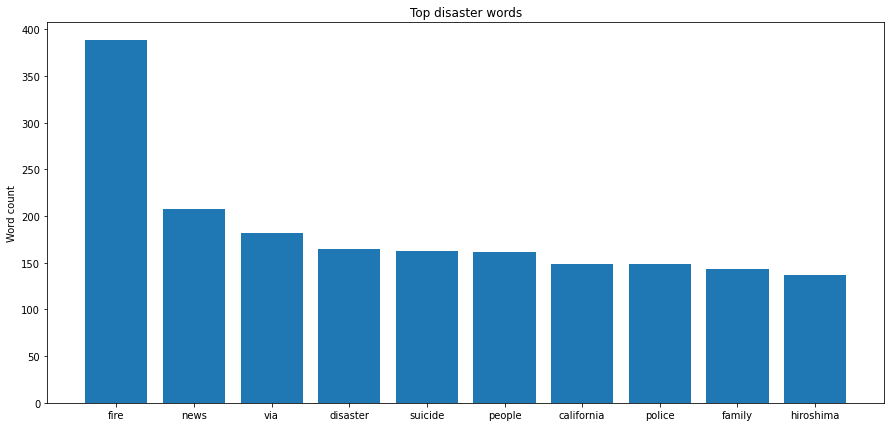

In [17]:
#bar chart for top 20 disaster word counts
plt.figure(figsize=[15, 7])
plt.bar(topWords_disaster, topWordCounts_disaster)
plt.ylabel("Word count")
plt.title("Top disaster words")
plt.show()

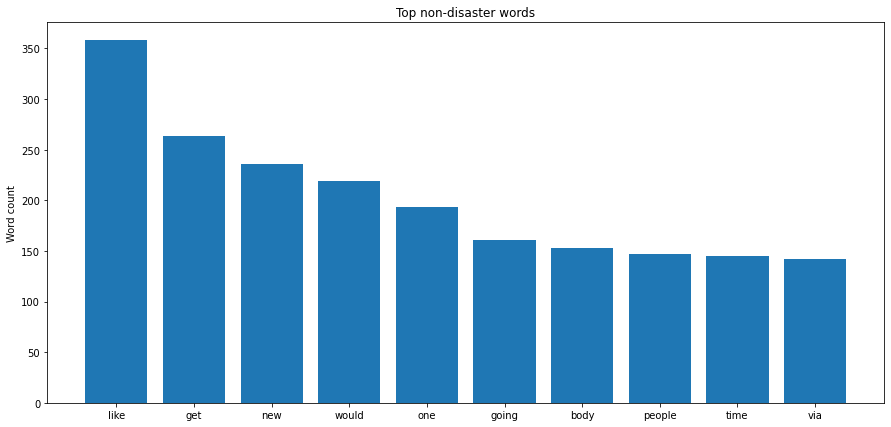

In [18]:
#bar chart for top 20 non-disaster word counts
plt.figure(figsize=[15, 7])
plt.bar(topWords_nonDisaster, topWordCounts_nonDisaster)
plt.ylabel("Word count")
plt.title("Top non-disaster words")
plt.show()

**Wordclouds**

In [19]:
disasterText = " ".join(tweet for tweet in disasterTweets.clean_text) #turn dataframe column into strings

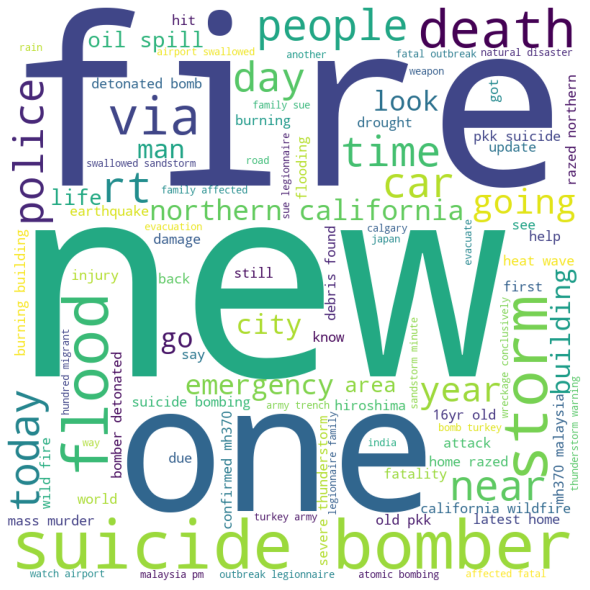

In [20]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(disasterText)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [21]:
nonDisasterText = " ".join(tweet for tweet in nonDisasterTweets.clean_text) #turn dataframe column into strings

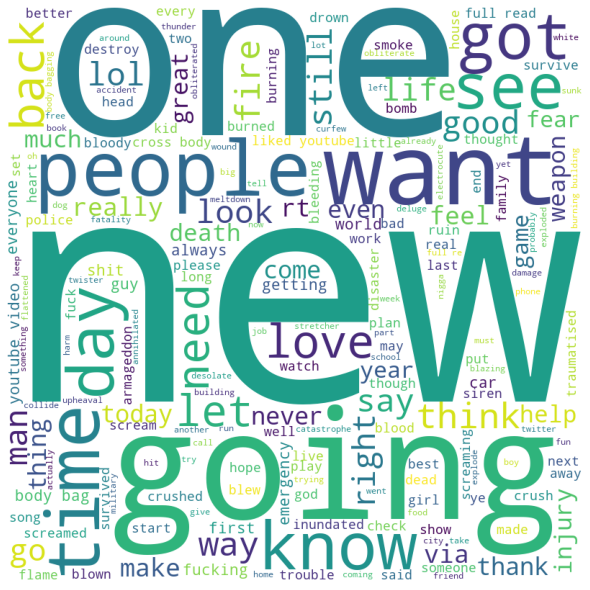

In [22]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(nonDisasterText)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

**Data vectorization**

Split dataset into test / train partitions

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(tweetData.clean_text, tweetData.target, test_size=0.3, random_state=42)

Train a word2vec model

In [24]:
#function to tokenize tweets
def tokenizer(tweets):
  tokenized_tweets = []
  for tweet in tweets:
    tokenized_tweets.append(str(tweet).split()) #split on whitespace
  return tokenized_tweets

tokenized_tweets = tokenizer(tweetData['clean_text']) #tokenize cleaned tweets

In [25]:
word2vec = gensim.models.Word2Vec(
            tokenized_tweets,
            vector_size=100, # number of dimension in each word vector
            min_count=1, # ignore all words with a total frequency lower than 1                                  
            sg = 1, # 1 for skip-gram model
            workers= 2, # number of cores to use
            epochs = 100
) 

KeyboardInterrupt: ignored

In [ ]:
#Vectorize a single tweet by finding the mean vector of every word in tweet
def vectorizeTweet(tokens, vector_size, model):
    vector = np.zeros((1, vector_size)) #numpy array
    count = 0
    for word in tokens:
        try:
            vector += model[word] #add vector of current word
            count = count + 1
        except KeyError:  # handling the case where the word is not in model's vocab
            continue
    if count != 0:
        vector /= count #get mean of tweet word vectors
    return vector

In [ ]:
#Vectorize all tweets
def vectorizeTweets(tokens, vector_size, model):
  tweetCount = len(tokens) #total num of tweets
  tweet_vectors = np.zeros((tweetCount, vector_size)) #array (num of tweets, vector size)

  for i in range (tweetCount): #call vectorizeTweet() on every tweet
      tweet_vectors[i] = vectorizeTweet(tokens[i], vector_size, model)
  return tweet_vectors

In [ ]:
xtrain_w2v = vectorizeTweets(tokenizer(X_train), 100, word2vec.wv) #store word2vec vectorized training data 
xtest_w2v = vectorizeTweets(tokenizer(X_test), 100, word2vec.wv) #store word2vec vectorized testing data 

Pre-trained word2vec

In [ ]:
#load model from file
#pretrainedModel = KeyedVectors.load_word2vec_format(fname="/content/drive/MyDrive/Disaster Tweets Data/glove.6B.100d.txt", no_header=True)

#load model by downloading using gensim API
pretrainedModel = gensim.downloader.load('glove-twitter-100')

In [ ]:
xtrain_pretrained = vectorizeTweets(tokenizer(X_train), 100, pretrainedModel) #store vectorized pretrained word2vec training data
xtest_pretrained = vectorizeTweets(tokenizer(X_test), 100, pretrainedModel) #store vectorized pretrained word2vec testing data

Count vectorizer

In [ ]:
countVectorizer = CountVectorizer()
xtrain_cv = countVectorizer.fit_transform(X_train) 
xtest_cv = countVectorizer.transform(X_test)

TFIDF Vectorizer

In [ ]:
tfidfVectorizer = TfidfVectorizer()
xtrain_tfidf = tfidfVectorizer.fit_transform(X_train)
xtest_tfidf = tfidfVectorizer.transform(X_test)

**Classification**

Create dictionaries to store classifiers, embeddings and the embebedded data forms

In [ ]:
classifiers = {'svm' :svm.SVC(), 
               'k_neighbours': KNeighborsClassifier(),
               'random_forest': RandomForestClassifier(),
               'logistic_regression': LogisticRegression(),
               'naive_bayes': GaussianNB() }
embeddings = {
    "Count vectorizer" : [xtrain_cv, xtest_cv],
    "TFIDF": [xtrain_tfidf, xtest_tfidf],
    "Word2vec" : [xtrain_w2v, xtest_w2v],
    "Pretrained word2vec" : [xtrain_pretrained, xtest_pretrained]
    }

In [ ]:
#Function for training a classifier given a classifier, training and testing data
def classify(classifier, xtrain, xtest):
  classifier.fit(xtrain, Y_train)
  return classifier.predict(xtest)

In [ ]:
#Function to train and get prediction of every model
def trainPredictModels():
  modelPredictions = {} #Store each model's predictions

  for classifier in classifiers.values(): #Loop over every classifier
    classifier_name = classifier.__class__.__name__
    modelPredictions[classifier_name] = {} 
    
    for embedding in embeddings: #Loop over every embedding
      #Train & predict for each model
      print("Classifying: " + classifier_name + " with " + embedding + " embedding...", end="")
      xtrain = embeddings[embedding][0]
      xtest = embeddings[embedding][1]

      #Count Vectorizer & TFIDF need to be converted to dense matrices for the Guassian classifier
      if(classifier_name == 'GaussianNB' and (embedding == "Count vectorizer" or embedding == "TFIDF")):
        predictions = classify(classifier, xtrain.toarray(), xtest.toarray()) #convert sparse matrix to dense
      else:
        predictions = classify(classifier, xtrain, xtest)

      print("Success!")
      modelPredictions[classifier_name][embedding] = predictions
      
  return modelPredictions

In [ ]:
#Create a dictionary storing each model's performance metrics
def evaluateModels(models):

    metrics = {'Classifier': [],
           'Embedding': [],
           'Accuracy': [],
           'F1': [],
           'Precision': [],
           'Recall': [] }

    for model in models:
      for embedding in models[model]:

        #extract predictions for current model 
        predictions = models[model][embedding]

        #calculate performance metrics and add to dictonary     
        metrics['Classifier'].append(model)
        metrics['Embedding'].append(embedding)
        metrics['Accuracy'].append(accuracy_score(Y_test, predictions))
        metrics['F1'].append(f1_score(Y_test, predictions))
        metrics['Precision'].append(precision_score(Y_test, predictions))
        metrics['Recall'].append(recall_score(Y_test, predictions))
    
    return metrics

In [ ]:
#Call the classification & evaluatiom models
modelPredictions = trainPredictModels()
metrics = evaluateModels(modelPredictions)

**Evaluation of pre-optmized models**

In [ ]:
#Show model performance table sorted by accuracy
metricsDF = pd.DataFrame(data=metrics)
metricsDF.sort_values(by='Accuracy', ascending=False)

In [ ]:
#Boxplot for classifier accuracy comparison
metricsDF.boxplot(by='Classifier', column='Accuracy', grid=False, figsize=(10,7))

In [ ]:
#Boxplot for word embedding type accuracy comparison
metricsDF.boxplot(by='Embedding', column='Accuracy', grid=False, figsize=(10,7))

In [ ]:
#Big bar char for each performance metric
metricsDF['Model'] = metricsDF['Classifier'] + ' ' + metricsDF['Embedding']
metricsDF.plot.barh(x='Model', y=['Accuracy','F1','Precision','Recall'], figsize=(20,25))

In [ ]:
#ROC AUCs for every model
for model in modelPredictions:
  plt.figure()
  plt.title(model)
  ax = plt.gca()
  for embedding in modelPredictions[model]:
    RocCurveDisplay.from_predictions(Y_test, modelPredictions[model][embedding], ax=ax, name=embedding)


In [ ]:
#Confusion matrices for top classifier (SVC)
for embedding in modelPredictions['SVC']:
  ConfusionMatrixDisplay.from_predictions(Y_test, modelPredictions['SVC'][embedding])
  plt.title(embedding)

**Exhaustive grid search for best model and hyper parameter tuning** 

In [ ]:
model_params = {
    'svm': {
        'model': svm.SVC(),
        'params' : {
            'C': [0.1, 1, 10],
            'kernel': ['poly', 'rbf', 'sigmoid']
        }  
    },
    'k_neighbours' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': list(range(1, 21, 2)),
            'weights': ['uniform', 'distance'],
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [100, 200, 500],
            'max_features': ['sqrt', 'log2'],
            'criterion' :['gini', 'entropy']
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(),
        'params': {
            'solver': ['lbfgs', 'liblinear'],
            'C': [1, 0.1, 0.01, 10],
            'penalty': ['l2'],
            'max_iter': [1000]
        }
    },
    'naive_bayes': { 
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-1, 1e-3, 1e-5, 1e-7, 1e-9, 1e-11, 1e-13, 1e-15, 1e-17]
        }
    }
}


Perform gridsearch and store results

In [ ]:
gridsearchResults = []
for model_name, mp in model_params.items(): #loop over each gridsearch space

    clf =  GridSearchCV(mp['model'], mp['params'], scoring='accuracy') #get current classifier

    for embedding in embeddings: #loop over each embedding type

      xtrain = embeddings[embedding][0] #get training data for current embedding

      #convert TFIDF & CV to dense matricies if on Guassian classifier
      if(mp['model'].__class__.__name__ == 'GaussianNB' and (embedding == "Count vectorizer" or embedding == "TFIDF")):
        clf.fit(xtrain.toarray(), Y_train) #convert sparse matrix to dense
      else:
        clf.fit(xtrain, Y_train)

      #Store grid search result for current model
      gridsearchResults.append({
        'classifier': model_name,
        'embedding': embedding,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })     

**Optimized models evalation**

Train optimized models on training data from initial evaluation. Get predictions for the testing data splits too.

In [ ]:
def trainPredictOptimizedModels():
  optimizedPredictions = {}  #dict to store each model's predictions

  for i in gridsearchResults: #loop over every model
    model = i['classifier']
    embedding = i['embedding']
    xtrain = embeddings[embedding][0] 
    xtest = embeddings[embedding][1]

    #check if current classifier already in dictionary
    if model not in optimizedPredictions: 
      optimizedPredictions[model] = {}

    #get classifier constructor and set its params to be optimal
    classifier = classifiers[model]
    classifier.set_params(**i['best_params'])

    classifier_name = classifier.__class__.__name__
    print("Classyfing", classifier_name, embedding, end="")

    #Gaussian Naive Bayes needs dense input. CV and TFIDF are sparse by default so convert them.
    if(classifier_name == 'GaussianNB' and (embedding == "Count vectorizer" or embedding == "TFIDF")):
      predictions = classify(classifier, xtrain.toarray(), xtest.toarray()) #convert sparse matrix to dense
    else:
      predictions = classify(classifier, xtrain, xtest)

    print("...Success!")

    optimizedPredictions[model][embedding] = predictions
  
  return optimizedPredictions

In [ ]:
optimizedPredictions = trainPredictOptimizedModels()
metrics_optimized = evaluateModels(optimizedPredictions)
metrics_optimized_DF = pd.DataFrame(data=metrics_optimized) #Put final evaluation metrics into dataframe form

In [ ]:
#Create ROC curves & get AUC scores
auc_scores = {}
for model in optimizedPredictions:
  plt.figure()
  plt.title(model)
  ax = plt.gca()
  for embedding in optimizedPredictions[model]:
    auc_scores[model + ' ' + embedding] = (roc_auc_score(Y_test, optimizedPredictions[model][embedding]))
    RocCurveDisplay.from_predictions(Y_test, optimizedPredictions[model][embedding], ax=ax, name=embedding)

In [ ]:
#Put AUC scores into ordered dataframe and display it
aucDF = pd.DataFrame(data=auc_scores, index=['AUC']).T.sort_values(by='AUC', ascending=False)
aucDF

In [ ]:
#Display final model evaluation table sorted by accuracy
metrics_optimized_DF.sort_values(by='Accuracy', ascending=False)

Calculate and print accuracy/F1/Precision/Recall score differences between non-optimized and optimized models

In [ ]:
print("Accuracy")
u_meanAcc = metricsDF['Accuracy'].mean()
t_meanAcc = metrics_optimized_DF['Accuracy'].mean()
meanAcc_diff = t_meanAcc - u_meanAcc
print('Untuned accuracy avg: {:.2f}%'.format(u_meanAcc*100))
print('Tuned accuracy avg: {:.2f}%'.format(t_meanAcc*100))
print('Change: {:.2f}%'.format(meanAcc_diff*100))

print("\nF1")
u_meanF1 = metricsDF['F1'].mean()
t_meanF1 = metrics_optimized_DF['F1'].mean()
meanF1_diff = t_meanF1 - u_meanF1
print('Untuned F1 avg: {:.2f}%'.format(u_meanF1*100))
print('Tuned F1 avg: {:.2f}%'.format(t_meanF1*100))
print('Change: {:.2f}%'.format(meanF1_diff*100))

print("\nPrecision")
u_meanPrecision = metricsDF['Precision'].mean()
t_meanPrecision = metrics_optimized_DF['Precision'].mean()
meanPrecision_diff = t_meanPrecision - u_meanPrecision
print('Untuned precision avg: {:.2f}%'.format(u_meanPrecision*100))
print('Tuned precision avg: {:.2f}%'.format(t_meanPrecision*100))
print('Change: {:.2f}%'.format(meanPrecision_diff*100))

print("\nRecall")
u_meanRecall = metricsDF['Recall'].mean()
t_meanRecall = metrics_optimized_DF['Recall'].mean()
meanRecall_diff = t_meanRecall - u_meanRecall
print('Untuned recall avg: {:.2f}%'.format(u_meanRecall*100))
print('Tuned recall avg: {:.2f}%'.format(t_meanRecall*100))
print('Change: {:.2f}%'.format(meanRecall_diff*100))

Display a bar chart showing the peformance metrics of every optimized model

In [ ]:
metrics_optimized_DF['Model'] = metricsDF['Classifier'] + ' ' + metricsDF['Embedding']
ax = metrics_optimized_DF.plot(kind='barh', x='Model', y=['Accuracy','F1','Precision','Recall'], title='Optimized model metrics', figsize=(13,25))
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
#Boxplot for optimized classifier accuracy performance
metrics_optimized_DF.boxplot(by='Classifier', column='Accuracy', grid=True, figsize=(10,7))

In [ ]:
##Boxplot for optimized embedding accuracy performance
metrics_optimized_DF.boxplot(by='Embedding', column='Accuracy', grid=True, figsize=(10,7))